In [16]:
# import seaborn as sns
import xarray as xr
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [17]:
def focused_year_skill(model_name: str):
    # Directory where this model's .nc files are located
    # input_dir = f"prod/{model_name}/converted_focused/"
    input_dir = f"testing_seasonal/{model_name}/converted_focused/"

    # Mapping of month abbreviation to month number to format pandas datetime
    month_to_num = {
        "Jan":1,
        "Feb":2,
        "Mar":3,
        "Apr":4,
        "May":5,
        "Jun":6,
        "Jul":7,
        "Aug":8,
        "Sep":9,
        "Oct":10,
        "Nov":11,
        "Dec":12,
    }

    all_monthly_datasets = []
    current_year = 2025

    # List of netCDF files in the directory
    nc_files = [file for file in os.listdir(input_dir) if file.endswith(".nc")]

    def get_month_num_from_name(filename):
        match = re.match(r'([A-Za-z]{3})IC_.*\.nc', filename)
        if match:
            month_abbr = match.group(1)
            return month_to_num.get(month_abbr, 0) #default to 0 for debugging
        return 0

    #functional key for sorting based on month
    nc_files.sort(key=get_month_num_from_name)

    for filename in nc_files:
        filepath = os.path.join(input_dir, filename)

        month_abbr_match = re.match(r'([A-Za-z]{3})IC_.*\.nc', filename)
        # Debugging print
        if not month_abbr_match:
            print(f"Could not match month abbreviation from '{filename}'.")
            continue

        month_abbr = month_abbr_match.group(1)
        month_num = month_to_num.get(month_abbr)

        # Debugging print
        if month_num is None:
            print(f"No number for month '{month_abbr}'. check dictionary.")
            continue

        try:
            #open file like in "to_open_netcdf.ipynb"
            ds = xr.open_dataset(filepath, decode_times=False)

            # Converting to pandas datetime the first day of the month
            correct_time = pd.to_datetime(f"{current_year}-{month_num}-01")

            # Update the dataset time
            ds = ds.assign_coords(time=[correct_time])

            # Finished processing
            all_monthly_datasets.append(ds)
        
        except Exception as e:
            print(f"Error processing '{filename}': {e}.")

    # Debugging stop
    if not all_monthly_datasets:
        raise ValueError("No files were processed.")

    # Concatenate datasets by time
    dataset = xr.concat(all_monthly_datasets, dim="time")

    # Converting longitudes to -180 to 180 format
    dataset = dataset.assign_coords(lon=(dataset['lon'] + 180) % 360 - 180)
    dataset = dataset.sortby('lon')

    # Convert month numbers to abbreviations for plotting labels
    num_to_month = {
        1:"Jan",
        2:"Feb",
        3:"Mar",
        4:"Apr",
        5:"May",
        6:"Jun",
        7:"Jul",
        8:"Aug",
        9:"Sep",
        10:"Oct",
        11:"Nov",
        12:"Dec",
    }
    # Adding month_name coordinate
    month_names = [num_to_month[month_num] for month_num in dataset['time'].dt.month.values]

    # Making sure months are in order
    month_order = [num_to_month[i] for i in sorted(num_to_month.keys())]
    month_names_categorical = pd.Categorical(month_names, categories=month_order, ordered=True)
    dataset = dataset.assign_coords(month_name=('time', month_names_categorical))

    # Debugging print
    # print("Combined dataset:", dataset, "\n", sep="\n")

    # lat and long into a 'space' dimension
    flattened_sk1 = dataset['sk1'].stack(space=('lat', 'lon'))

    # Change xarray dataset to pandas dataframe for seaborn compatibility
    df_sk1 = flattened_sk1.to_series().reset_index()

    # Month for categorical box plot
    df_sk1['month_name'] = df_sk1['time'].dt.month.map(num_to_month)
    df_sk1['month_name'] = pd.Categorical(df_sk1['month_name'], categories=month_order, ordered=True)

    # Debugging print
    # print(df_sk1)

    # ####### PLOTTING BOX PLOTS #######
    # plt.figure(figsize=(14,7))
    # sns.boxplot(
    #     data=df_sk1, # Dataframe to plot
    #     x="month_name", # Categorical x axis
    #     y="sk1", # Precipitation Lead-1 skill on y axis
    #     showfliers=True
    # )
    # plt.title("NMME Surface Precipitation Lead-1 Skill")
    # plt.xlabel("Month")
    # plt.ylabel("Lead-1 Skill")
    # plt.grid(axis="y", linestyle="--", alpha=0.7)
    # plt.xticks(rotation=45, ha="right") # Rotating for space
    # plt.tight_layout()
    # plt.show()

    # ###### PLOTTING LINE PLOT WITH PERCENTILES #######
    # percentiles = [10, 90]
    # sk1_percentiles = flattened_sk1.quantile(q=[p / 100 for p in percentiles], dim="space")
    # print(sk1_percentiles)
    # sk1_mean = flattened_sk1.mean(dim="space")

    # # Changing percentiles to columns and time to index
    # sk1_percentiles_df = sk1_percentiles.to_dataframe("sk1_value").unstack(level='quantile')
    # sk1_percentiles_df.columns = [f'P{int(q*1)}' for q in percentiles] # Renaming columns

    # plt.figure(figsize=(14, 7))
    # for col in sk1_percentiles_df.columns:
    #     plt.plot(sk1_percentiles_df.index, sk1_percentiles_df[col], label=col, linestyle="--", linewidth=2)
    # plt.plot(sk1_mean.time, sk1_mean, label="Mean", color='black', linestyle='-', linewidth=2)
    # plt.title("NMME Surface Precipitation Lead-1 Skill")
    # plt.xlabel("Time")
    # plt.ylabel("Lead-1 Skill")
    # plt.legend(title="Percentile")
    # plt.grid(True, linestyle="--", alpha=0.7)
    # plt.tight_layout()
    # plt.show()

    #### PLOTTING LINE PLOT PER LONGITUDE #####
    plt.figure(figsize=(14,7))
    sk1_data = dataset["sk1"]

    # Debugging print
    # print(sk1_data)

    # Mean skill to visually compare models
    sk1_mean = sk1_data.mean(dim=['lat', 'lon'])

    for lon_val in sk1_data['lon'].values:
        # squeeze() to remove latitude dimension because it is a singleton at the moment
        line_data = sk1_data.sel(lon=lon_val, method='nearest').squeeze()
        plt.plot(line_data['month_name'], line_data, label=f'Lon: {lon_val:.1f}', linewidth=1)

    plt.plot(sk1_mean['month_name'], sk1_mean, label="Mean Skill", color="black", linestyle="-", linewidth=2)

    plt.title(f"{model_name} Seasonal Surface Precipitation Lead-1 Skill")
    plt.xlabel("Time")
    plt.ylabel("Lead-1 Skill")
    plt.legend(title="Longitudes and Mean")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.yticks(np.arange(-1.0, 1.1, 0.1))
    plt.tight_layout()
    # plt.show()
    # "C:\Users\jorge\OneDrive\Desktop\Plots\NMME Surface Precipitation Lead-1 Skill.png"
    plt.savefig(f"testing_seasonal/plots/{model_name} Seasonal Surface Precipitation Lead-1 Skill.png")

    print(f"Plotted Year long seasonal skill for {model_name}.")

Plotted Year long seasonal skill for NMME.
Plotted Year long seasonal skill for CFSv2.
Plotted Year long seasonal skill for CCSM4.
Plotted Year long seasonal skill for CESM1.
Plotted Year long seasonal skill for GEOS-5 (NASA).


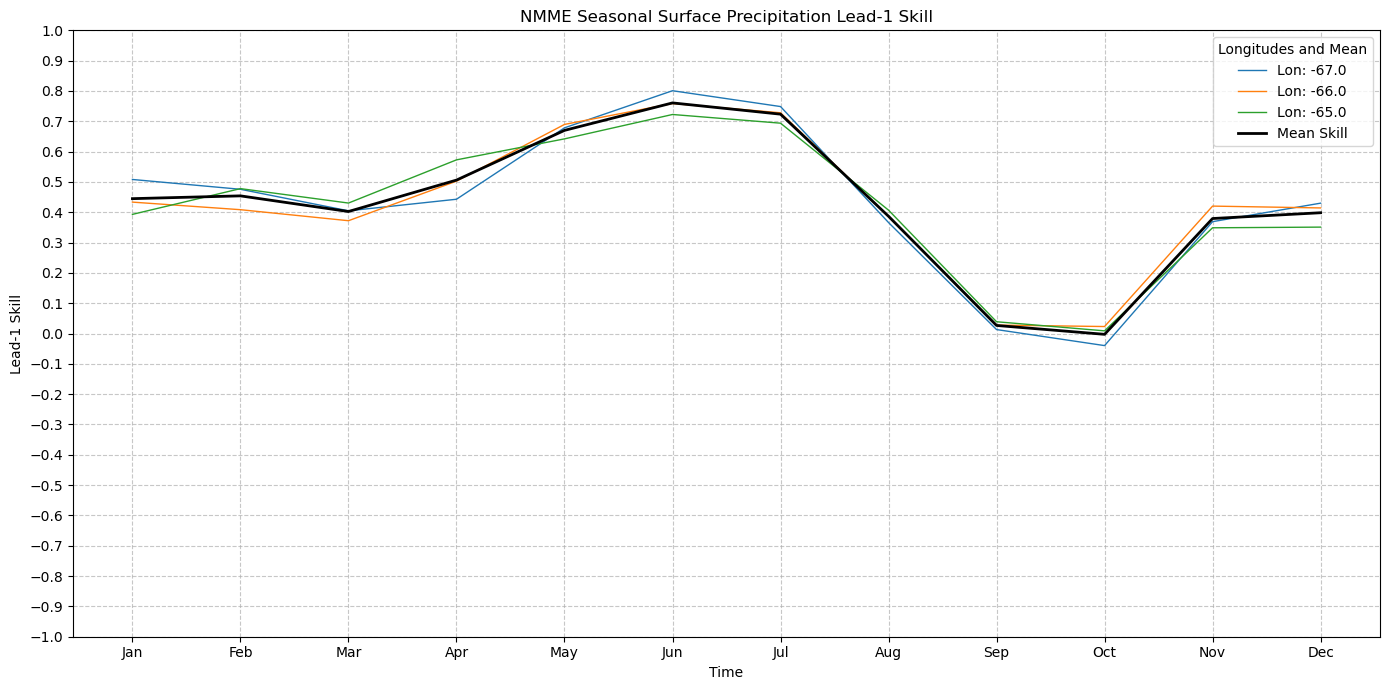

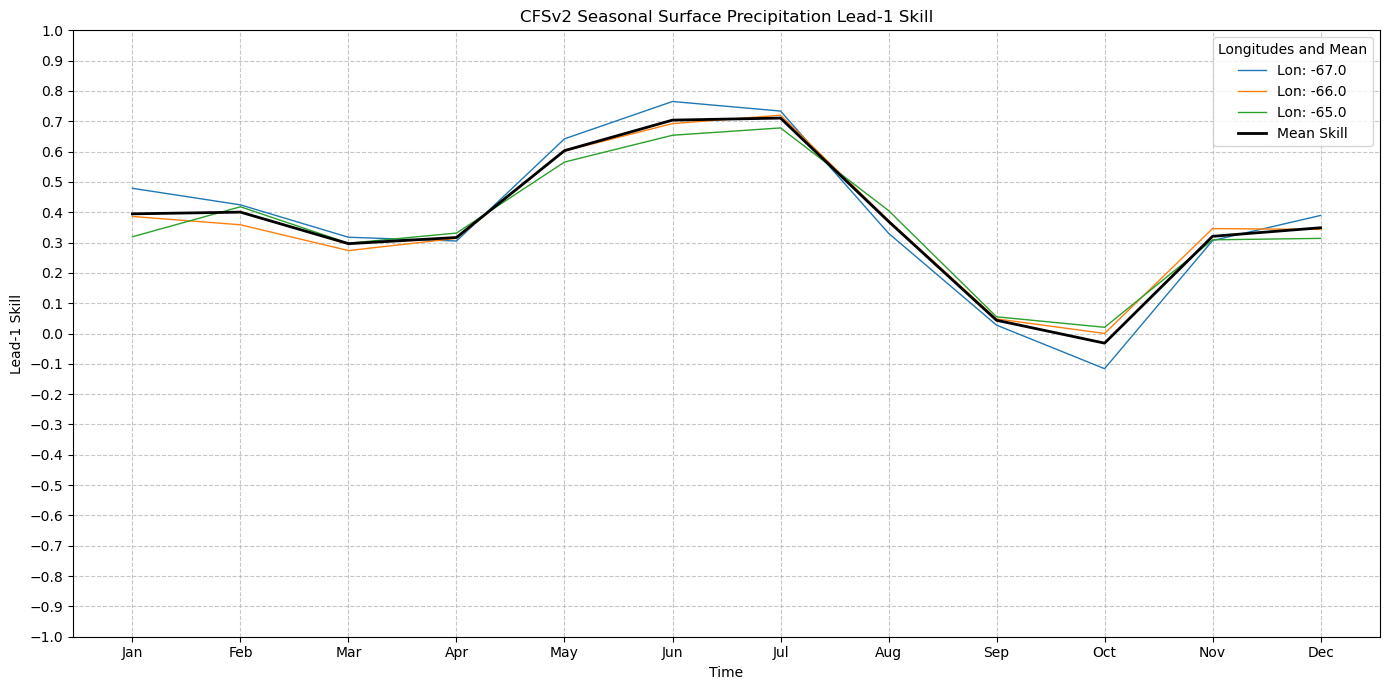

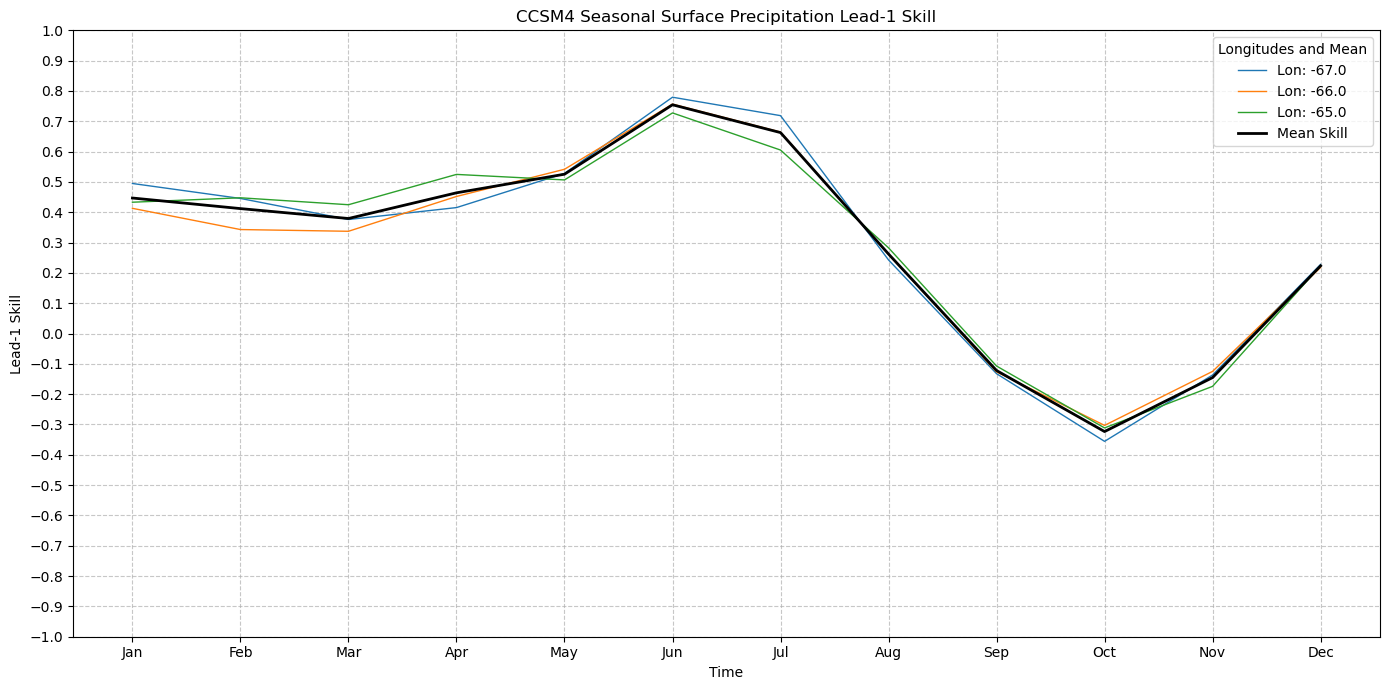

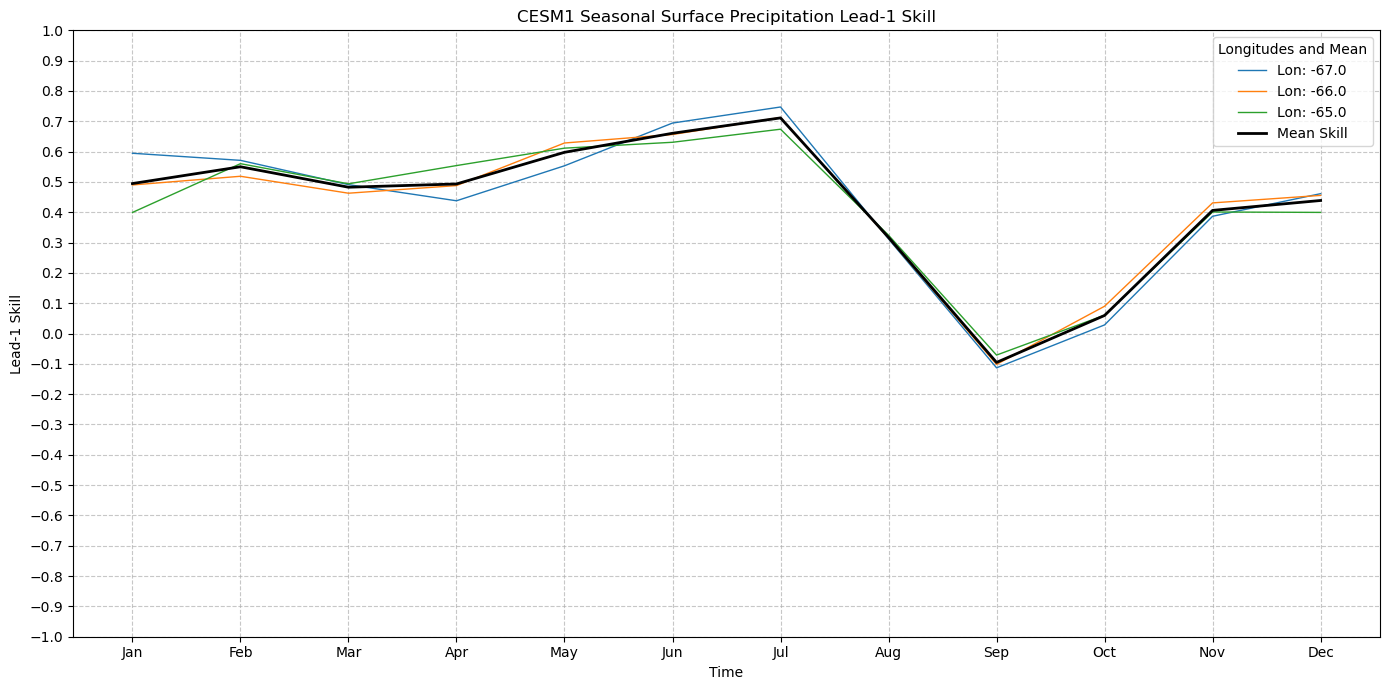

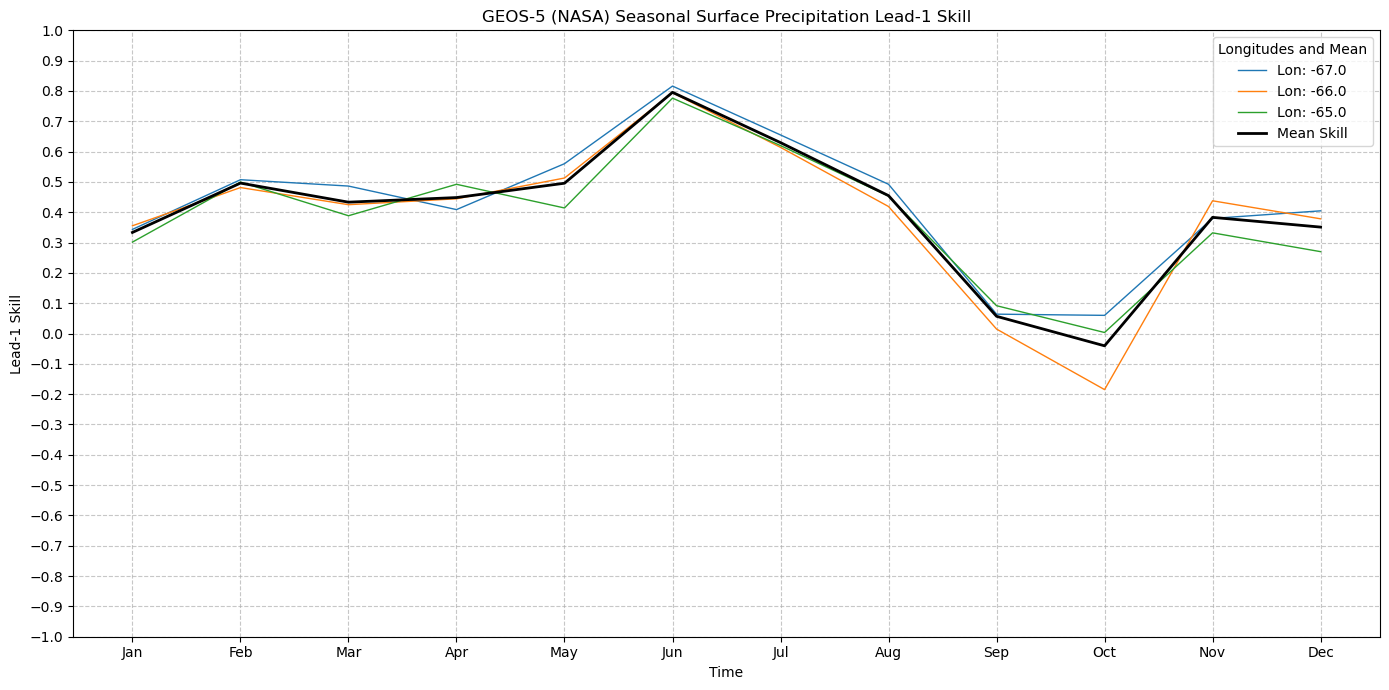

In [18]:
for model_name in ["NMME", "CFSv2", "CCSM4", "CESM1", "GEOS-5 (NASA)"]:
    focused_year_skill(model_name)